# AURA Simple: DeBERTa-v3-base Reporting-Aware Toxicity Detection

**Philosophy**: A more powerful model can learn nuances directly.

**Architecture**: `microsoft/deberta-v3-base` → Binary Classification Head

**Dataset**: Unified Toxicity + Reporting (18k samples)
- Label 0: Non-toxic OR Reporting (safe content)
- Label 1: Toxic direct speech

**Goal**: The model should learn that *reporting* toxic content is NOT toxic.

---

In [1]:
# Cell 1: Setup & GPU Check
import torch
print("🔧 Checking GPU...")
if torch.cuda.is_available():
    print(f"✅ GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("⚠️ No GPU! Enable in Settings → Accelerator → GPU")

🔧 Checking GPU...
✅ GPU: Tesla T4
   Memory: 15.6 GB


In [2]:
# Cell 2: Imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'🔧 Device: {device}')

🔧 Device: cuda


In [3]:
# Cell 3: Configuration
CONFIG = {
    'model_name': 'microsoft/deberta-v3-base',
    'max_length': 128,
    'batch_size': 16,
    'epochs': 5,
    'lr': 2e-5,
    'weight_decay': 0.01,
    'warmup_ratio': 0.1,
    'patience': 3,
}

DATA_DIR = '/kaggle/input/aura-deberta-data'

print('📋 Configuration:')
for k, v in CONFIG.items():
    print(f'   {k}: {v}')

📋 Configuration:
   model_name: microsoft/deberta-v3-base
   max_length: 128
   batch_size: 16
   epochs: 5
   lr: 2e-05
   weight_decay: 0.01
   warmup_ratio: 0.1
   patience: 3


In [4]:
# Cell 4: Dataset Class
class ToxicityDataset(Dataset):
    def __init__(self, path, tokenizer, max_len):
        self.df = pd.read_csv(path)
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        enc = self.tokenizer(
            str(row['text']),
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': enc['input_ids'].flatten(),
            'attention_mask': enc['attention_mask'].flatten(),
            'label': torch.tensor(int(row['label']), dtype=torch.long)
        }

print('📦 Dataset class defined.')

📦 Dataset class defined.


In [5]:
# Cell 5: Load Data
tokenizer = AutoTokenizer.from_pretrained(CONFIG['model_name'])

train_ds = ToxicityDataset(f"{DATA_DIR}/deberta_unified_train.csv", tokenizer, CONFIG['max_length'])
val_ds = ToxicityDataset(f"{DATA_DIR}/deberta_unified_val.csv", tokenizer, CONFIG['max_length'])

train_loader = DataLoader(train_ds, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=CONFIG['batch_size'], shuffle=False)

print('='*60)
print('📊 DATASET SUMMARY')
print('='*60)
print(f'Training samples: {len(train_ds):,}')
print(f'Validation samples: {len(val_ds):,}')

# Check distribution
train_df = pd.read_csv(f"{DATA_DIR}/deberta_unified_train.csv")
print(f'\nLabel distribution (train):')
print(f'   0 (Safe/Reporting): {(train_df["label"] == 0).sum():,}')
print(f'   1 (Toxic Direct):   {(train_df["label"] == 1).sum():,}')

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

📊 DATASET SUMMARY
Training samples: 18,375
Validation samples: 1,397

Label distribution (train):
   0 (Safe/Reporting): 11,224
   1 (Toxic Direct):   7,151


In [6]:
# Cell 6: Load Model
model = AutoModelForSequenceClassification.from_pretrained(
    CONFIG['model_name'],
    num_labels=2
).to(device)

# Class weights for imbalance
n_safe = (train_df['label'] == 0).sum()
n_toxic = (train_df['label'] == 1).sum()
class_weights = torch.tensor([n_toxic / n_safe, 1.0], device=device, dtype=torch.float32)
print(f'⚖️ Class weights: {class_weights}')

criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['lr'], weight_decay=CONFIG['weight_decay'])

# Scheduler
total_steps = len(train_loader) * CONFIG['epochs']
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(total_steps * CONFIG['warmup_ratio']),
    num_training_steps=total_steps
)

print(f'\n🏗️ Model loaded: {CONFIG["model_name"]}')
print(f'   Parameters: {sum(p.numel() for p in model.parameters()):,}')

2026-01-30 19:01:33.790301: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769799694.027238      23 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769799694.095426      23 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769799694.669730      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769799694.669770      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769799694.669773      23 computation_placer.cc:177] computation placer alr

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


⚖️ Class weights: tensor([0.6371, 1.0000], device='cuda:0')

🏗️ Model loaded: microsoft/deberta-v3-base
   Parameters: 184,423,682


In [7]:
# Cell 7: Training Functions
def train_epoch(model, loader, optimizer, scheduler, criterion):
    model.train()
    total_loss = 0
    
    for batch in tqdm(loader, desc='Training'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
    
    return total_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = outputs.logits.argmax(dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch['label'].numpy())
    
    f1 = f1_score(all_labels, all_preds, average='macro')
    return f1, all_preds, all_labels

print('✅ Training functions defined.')

✅ Training functions defined.


In [8]:
# Cell 8: Training Loop
print('='*60)
print('🚀 TRAINING START')
print('='*60)

best_f1 = 0
patience_counter = 0
history = {'train_loss': [], 'val_f1': []}

for epoch in range(1, CONFIG['epochs'] + 1):
    print(f'\n--- Epoch {epoch}/{CONFIG["epochs"]} ---')
    
    train_loss = train_epoch(model, train_loader, optimizer, scheduler, criterion)
    val_f1, _, _ = evaluate(model, val_loader)
    
    history['train_loss'].append(train_loss)
    history['val_f1'].append(val_f1)
    
    print(f'Train Loss: {train_loss:.4f} | Val F1: {val_f1:.4f}')
    
    if val_f1 > best_f1:
        best_f1 = val_f1
        patience_counter = 0
        torch.save(model.state_dict(), '/kaggle/working/deberta_best.pt')
        print('>>> BEST MODEL SAVED <<<')
    else:
        patience_counter += 1
        print(f'(Patience: {patience_counter}/{CONFIG["patience"]})')
        if patience_counter >= CONFIG['patience']:
            print('🛑 Early stopping.')
            break

print(f'\n🏆 Best F1: {best_f1:.4f}')

🚀 TRAINING START

--- Epoch 1/5 ---


Training:   0%|          | 0/1149 [00:00<?, ?it/s]

Train Loss: 0.4069 | Val F1: 0.7761
>>> BEST MODEL SAVED <<<

--- Epoch 2/5 ---


Training:   0%|          | 0/1149 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Train Loss: 0.2761 | Val F1: 0.7963
>>> BEST MODEL SAVED <<<

--- Epoch 3/5 ---


Training:   0%|          | 0/1149 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Train Loss: 0.2065 | Val F1: 0.7870
(Patience: 1/3)

--- Epoch 4/5 ---


Training:   0%|          | 0/1149 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Train Loss: 0.1430 | Val F1: 0.7762
(Patience: 2/3)

--- Epoch 5/5 ---


Training:   0%|          | 0/1149 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Train Loss: 0.1019 | Val F1: 0.7754
(Patience: 3/3)
🛑 Early stopping.

🏆 Best F1: 0.7963


🔬 FINAL EVALUATION

--- Classification Report ---
                precision    recall  f1-score   support

Safe/Reporting       0.84      0.90      0.87       911
         Toxic       0.78      0.68      0.73       486

      accuracy                           0.82      1397
     macro avg       0.81      0.79      0.80      1397
  weighted avg       0.82      0.82      0.82      1397



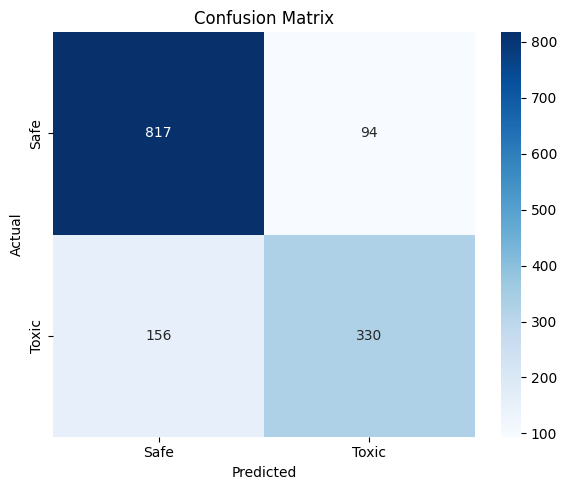

In [9]:
# Cell 9: Final Evaluation
print('='*60)
print('🔬 FINAL EVALUATION')
print('='*60)

model.load_state_dict(torch.load('/kaggle/working/deberta_best.pt'))
f1, preds, labels = evaluate(model, val_loader)

print('\n--- Classification Report ---')
print(classification_report(labels, preds, target_names=['Safe/Reporting', 'Toxic']))

# Confusion Matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Safe', 'Toxic'], yticklabels=['Safe', 'Toxic'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

In [10]:
# Cell 10: Qualitative Stress Test - Does it understand Reporting?
print('='*80)
print('🧪 QUALITATIVE STRESS TEST: REPORTING AWARENESS')
print('='*80)

test_cases = [
    # Reporting (should be SAFE)
    ("He said you are a disgusting person", "Safe", "Reporting"),
    ("According to the witness, 'you are an idiot'", "Safe", "Reporting"),
    ("She claims he called her a failure", "Safe", "Reporting"),
    ("The document records the insult: 'you are worthless'", "Safe", "Reporting"),
    
    # Direct Toxic (should be TOXIC)
    ("You are a disgusting person", "Toxic", "Direct"),
    ("I am telling you that you are an idiot", "Toxic", "Direct"),
    ("You are a failure and everyone knows it", "Toxic", "Direct"),
    ("You are worthless garbage", "Toxic", "Direct"),
    
    # Implicit Hate (should be TOXIC)
    ("People like you belong in a cage", "Toxic", "Implicit"),
    ("Your kind is inferior", "Toxic", "Implicit"),
    
    # Non-toxic (should be SAFE)
    ("I hate rainy Mondays", "Safe", "General"),
    ("This soup is disgusting", "Safe", "Object"),
    ("The movie was terrible", "Safe", "Opinion"),
]

print(f"{'Text':<50} | {'Expected':<8} | {'Pred':<8} | {'Status'}")
print('-'*80)

correct = 0
model.eval()

with torch.no_grad():
    for text, expected, category in test_cases:
        enc = tokenizer(text, max_length=CONFIG['max_length'], padding='max_length',
                        truncation=True, return_tensors='pt')
        outputs = model(enc['input_ids'].to(device), attention_mask=enc['attention_mask'].to(device))
        pred_idx = outputs.logits.argmax(dim=1).item()
        pred_label = 'Toxic' if pred_idx == 1 else 'Safe'
        
        status = '✅' if pred_label == expected else '❌'
        if pred_label == expected:
            correct += 1
        
        print(f"{text[:48]:<50} | {expected:<8} | {pred_label:<8} | {status}")

print('-'*80)
print(f'\n🎯 Stress Test Accuracy: {correct}/{len(test_cases)} ({correct/len(test_cases)*100:.1f}%)')
print('\n📝 Key Question: Does it correctly identify REPORTING as SAFE?')

🧪 QUALITATIVE STRESS TEST: REPORTING AWARENESS
Text                                               | Expected | Pred     | Status
--------------------------------------------------------------------------------
He said you are a disgusting person                | Safe     | Safe     | ✅
According to the witness, 'you are an idiot'       | Safe     | Safe     | ✅
She claims he called her a failure                 | Safe     | Safe     | ✅
The document records the insult: 'you are worthl   | Safe     | Safe     | ✅
You are a disgusting person                        | Toxic    | Toxic    | ✅
I am telling you that you are an idiot             | Toxic    | Toxic    | ✅
You are a failure and everyone knows it            | Toxic    | Toxic    | ✅
You are worthless garbage                          | Toxic    | Toxic    | ✅
People like you belong in a cage                   | Toxic    | Toxic    | ✅
Your kind is inferior                              | Toxic    | Toxic    | ✅
I hate rainy Mondays

In [11]:
# Cell 11: Save Artifacts
print('💾 Saving artifacts...')

import json
with open('/kaggle/working/deberta_history.json', 'w') as f:
    json.dump(history, f)

print('✅ Model: /kaggle/working/deberta_best.pt')
print('✅ History: /kaggle/working/deberta_history.json')
print(f'\n🏆 Final Best F1: {best_f1:.4f}')

💾 Saving artifacts...
✅ Model: /kaggle/working/deberta_best.pt
✅ History: /kaggle/working/deberta_history.json

🏆 Final Best F1: 0.7963
